In [58]:
import os
import csv
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random

In [69]:
image_dir = './ISIC_UDA-1_1'
images = os.listdir(image_dir)
# print('names', images)
X = []
y = []
cancer_count = 0
with open('ISIC-2017_Training_Part3_GroundTruth.csv', 'r') as csvfile:
    filereader = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in filereader:
        if i != 0:      
#             print(row[0])
            while (images[i].rstrip('.jpg') != row[0]):
                i += 1
                if i == len(images):
                    break
#             if i == 10:
            if i == len(images):
                    break
            if row[1] == '1.0':
                cancer_count += 1
                label = 'CANCER'
            else:
                label = 'NOT_CANCER'
            img = mpimg.imread('{}/{}'.format(image_dir, images[i]))
            img = scipy.misc.imresize(arr=img, size=(120, 160, 3))
            img_arr = np.asarray(img)
            X.append(img_arr)
            y.append(label)
    
        i += 1
X = np.asarray(X)
y = np.asarray(y)
print('cancer', cancer_count)
print('x', X.shape)
print('y', y.shape)
#     for row in filereader:
#         print(row)
#         if row[0] == 'ISIC_0000556':
#             break

cancer 114
x (456, 120, 160, 3)
y (456,)


In [66]:
def augment_brightness(image):
    new_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright = .25 + np.random.uniform()
    new_image[:, :, 2] = new_image[:, :, 2]*random_bright
    new_image = cv2.cvtColor(new_image, cv2.COLOR_HSV2RGB)
    return new_image

def transform_image(img, ang_range, shear_range, trans_range, brightness=0):

    #  rotate
    ang_rot = np.random.uniform(ang_range) - ang_range / 2
    rows, cols, ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2, rows/2), ang_rot, 1)

    #  translate
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    
    #shear
    pts1 = np.float32([[5, 5], [20, 5], [5, 20]])
    pt1 = 5 + shear_range * np.random.uniform() - shear_range/2
    pt2 = 20 + shear_range * np.random.uniform() - shear_range/2
    
    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])
    
    shear_M = cv2.getAffineTransform(pts1, pts2)
    
    img = cv2.warpAffine(img, Rot_M, (cols, rows))
    img = cv2.warpAffine(img, Trans_M, (cols, rows))
    img = cv2.warpAffine(img, shear_M, (cols, rows))
    
    if brightness == 1:
        img = augment_brightness(img)
        
    return img

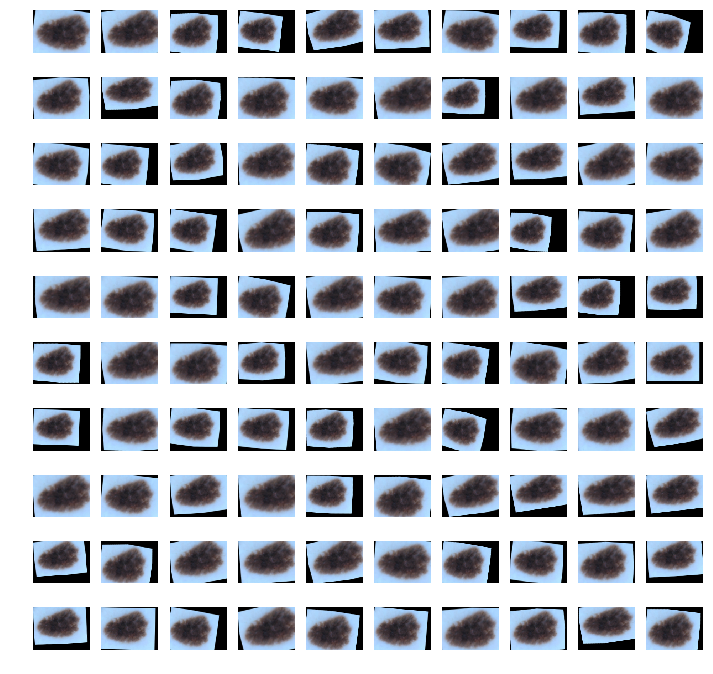

In [68]:
image = X[0]
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02)
plt.figure(figsize=(12, 12))
for i in range(100):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = transform_image(image, 20, 7, 5, brightness=0)
    
    plt.subplot(10, 10, i+1)
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

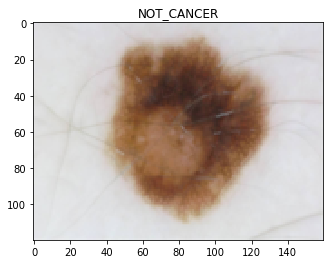

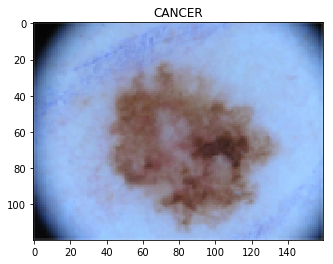

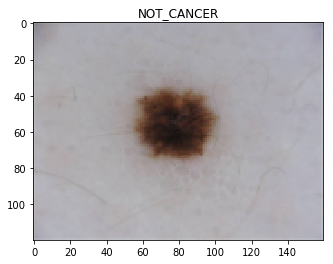

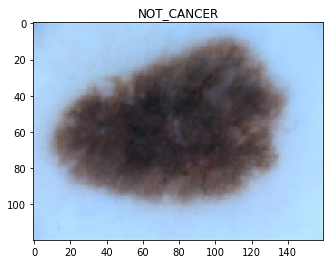

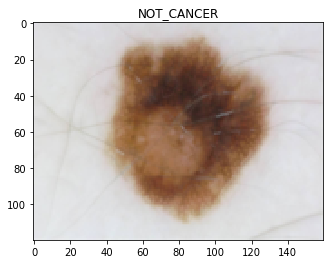

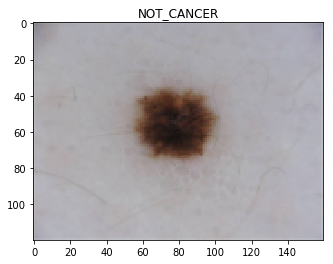

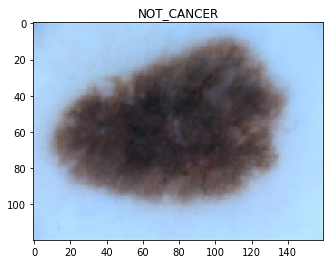

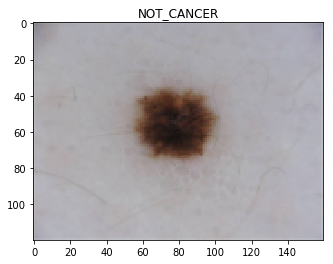

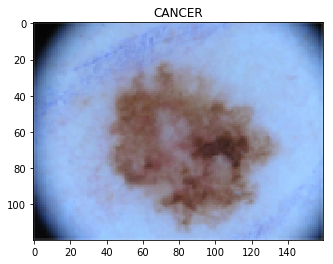

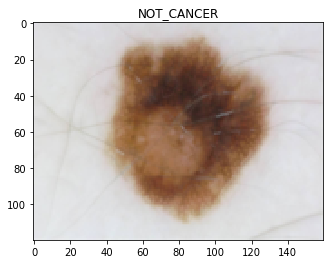

In [50]:
def print10():
#     if (canc):
#         imgs = cancer
#     else:
#         imgs = not_cancer
    for i in range(0, 10):
        rand = random.randint(0, X.shape[3])
        img = X[rand]
        plt.imshow(img)
        plt.title(y[rand])
        plt.show()
        
# print('cancer')
print10()
# print(random.randint(0, len(cancer)))
# img = mpimg.imread(image_dir + '/' + not_cancer[12])
# plt.imshow(img)
# plt.show()

In [73]:
new_X = []
new_y = []
for idx, (img, text) in enumerate(zip(X,y)):
    if text=='CANCER':
        for i in range(0, 48):
            image = transform_image(img, 20, 7, 5, brightness=0)
            new_X.append(image)
            new_y.append(text)
    else:
        for i in range(0, 16):
            image = transform_image(img, 20, 7, 5, brightness=0)
            new_X.append(image)
            new_y.append(text)
            
new_X = np.asarray(new_X)
new_y = np.asarray(new_y)
print('x', new_X.shape)
print('y', new_y.shape)

x (10944, 120, 160, 3)
y (10944,)


In [29]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers import Dense
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import scipy

In [30]:
epochs = 20
batch_size = 32

In [37]:
def make_model():
    model = Sequential()
    model.add(Lambda(lambda x: x * 1./255., input_shape=(120, 160, 3), output_shape=(120, 160, 3)))
    model.add(Conv2D(32, 3, 3, input_shape=(120, 160, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
    

In [38]:
model = make_model()
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 120, 160, 3)   0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 118, 158, 32)  896         lambda_4[0][0]                   
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 118, 158, 32)  0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 59, 79, 32)    0           activation_4[0][0]               
___________________________________________________________________________________________

In [74]:
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.1, random_state=0)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

print(y_train[:10])
print(y_test[:10])
print(X_train.shape)

[1 1 0 1 0 0 0 1 0 1]
[1 0 1 0 1 1 1 0 0 0]
(9849, 120, 160, 3)


In [ ]:
model = make_model()

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    nb_epoch=epochs,
    shuffle=True,
    batch_size=batch_size)

model.save_weights('binary_model.h5')

Train on 7879 samples, validate on 1970 samples
Epoch 1/20
7879/7879 [==============================] - 323s - loss: 0.6833 - acc: 0.5459 - val_loss: 0.6597 - val_acc: 0.6046
Epoch 2/20
7879/7879 [==============================] - 323s - loss: 0.6566 - acc: 0.6097 - val_loss: 0.6469 - val_acc: 0.6076
Epoch 3/20
7879/7879 [==============================] - 307s - loss: 0.6313 - acc: 0.6343 - val_loss: 0.6171 - val_acc: 0.6645
Epoch 4/20
1440/7879 [====>.........................] - ETA: 224s - loss: 0.6145 - acc: 0.6528